# core

> Create messages for language models like Claude and OpenAI GPTs.

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import base64
import mimetypes
from collections import abc

from fastcore import imghdr
from fastcore.meta import delegates
from fastcore.utils import *

## API Exploration
Anthropic's Claude and OpenAI's GPT models are some of the most popular LLMs. 

Let's take a look at their APIs and to learn how we should structure our messages for a simple text chat.

#### openai
```python
from openai import OpenAI
client = OpenAI()

client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
    {"role": "user", "content": "Hello, world!"}
  ]
)
```

#### anthropic
```python
from anthropic import Anthropic
client = Anthropic()

client.messages.create(
    model="claude-3-haiku-20240307",
    max_tokens=1024,
    messages=[
        {"role": "user", "content": "Hello, world!"}
    ]
)
```

As we can see both APIs use the exact same message structure.

### mk_msg
Ok, let's build the first version of `mk_msg` to handle this case

In [ ]:
def mk_msg(content:str, role:str="user")->dict:
    "Create an OpenAI/Anthropic compatible message."
    return dict(role=role, content=content)

Let's test it out with the OpenAI API. To do that we'll need to setup two things:

- install the openai SDK by running `pip install openai`
- add your openai api key to your env vars `export OPENAI_API_KEY="YOUR_OPEN_API_KEY"`

In [ ]:
%%capture
!pip install openai 

In [ ]:
from openai import OpenAI

In [ ]:
client = OpenAI()

r = client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[mk_msg("Hello, world!")]
)
r.choices[0].message.content

'Hello! How can I assist you today?'

Now, let's test out `mk_msg` on the Anthropic API. To do that we'll need to setup two things:

- install the openai SDK by running `pip install anthropic`
- add your anthropic api key to your env vars `export ANTHROPIC_API_KEY="YOUR_ANTHROPIC_API_KEY"`

In [ ]:
%%capture
!pip install anthropic

In [ ]:
from anthropic import Anthropic

In [ ]:
client = Anthropic()

r = client.messages.create(
    model="claude-3-haiku-20240307",
    max_tokens=1024,
    messages=[mk_msg("Hello, world!")]
)
r.content[0].text

"Hello! It's nice to meet you. How are you doing today?"

So far so good!

#### Helper Functions
Before going any further, let's create some helper functions to make it a little easier to call the OpenAI and Anthropic APIs. We're going to be making a bunch of API calls to test our code and typing the full expressions out each time will become a little tedious. These functions won't be included in the final package.

In [ ]:
oa_cli = OpenAI()

def openai_chat(msgs: list)->tuple:
    "call the openai chat completions endpoint with `msgs`."
    r = oa_cli.chat.completions.create(model="gpt-4o-mini", messages=msgs)
    return r, r.choices[0].message.content

a_cli = Anthropic()

def anthropic_chat(msgs: list)->tuple:
    "call the anthropic messages endpoint with `msgs`."
    r = a_cli.messages.create(model="claude-3-haiku-20240307", max_tokens=1024, messages=msgs)
    return r, r.content[0].text

Let's double check that `mk_msg` still works with our simple text example from before.

In [ ]:
_, text = openai_chat([mk_msg("Hello, world!")])
text

'Hello! How can I assist you today?'

and Anthropic...

In [ ]:
_, text = anthropic_chat([mk_msg("Hello, world!")])
text

"Hello! It's nice to meet you. How can I assist you today?"

### Images
Ok, let's see how both APIs handle image messages.

<img src="https://www.atshq.org/wp-content/uploads/2022/07/shutterstock_1626122512.jpg" height=240 width=240></img>

#### openai
```python
import base64
import httpx
from openai import OpenAI


mtype = "image/jpeg"
img = base64.b64encode(httpx.get(SOME_IMAGE_URL).content).decode("utf-8")

client = OpenAI()
client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role":"user",
            "content": [
                {"type":"text","text":"What's in this image?"},
                {"type":"image_url","image_url":{"url":f"data:{mtype};base64,{img}"}},
            ],
        }
    ],
)
```

#### anthropic
```python
import base64
import httpx
from anthropic import Anthropic


mtype = "image/jpeg"
img = base64.b64encode(httpx.get(SOME_IMAGE_URL).content).decode("utf-8")

client = Anthropic()
client.messages.create(
    model="claude-3-haiku-20240307",
    max_tokens=1024,
    messages=[
        {
            "role":"user",
            "content": [
                {"type":"text","text":"What's in this image?"},
                {"type":"image","source":{"type":"base64","media_type":mtype,"data":img}}
            ],
        }
    ],
)
```

Both APIs format images slightly differently and the structure of the message `content` is a litte more complex. 

In a text chat, `content` is a simple string but for a multimodal chat (text+images) we can see that `content` is a list of dictionaries.

### Msg Class
To handle the additional complexity of the multimodal messages let's build a `Msg` class. 

We'll keep it simple for now and just make sure that we can handle a text chat before expanding it to handle images.

In [ ]:
class Msg:
    "Helper class to create a message for the OpenAI and Anthropic APIs."
    def __call__(self, role:str, content:str, **kw)->dict:
        "Create an OpenAI/Anthropic compatible message with `role` and `content`."
        return dict(role=role, content=content)

Now, let's update `mk_msg` to use `Msg`.

In [ ]:
def mk_msg(content:str, role:str="user", **kw)->dict:
    "Create an OpenAI/Anthropic compatible message."
    return Msg()(role, content, **kw)

Let's add support for the more complicated `content` data structure.

```json
{
    "role": "user",
    "content": [{"type": "text", "text": "What's in this image?"}],
}
```

In [ ]:
class Msg:
    "Helper class to create a message for the OpenAI and Anthropic APIs."
    def __call__(self, role:str, content:str, **kw)->dict:
        "Create an OpenAI/Anthropic compatible message with `role` and `content`."
        return dict(role=role, content=[{"type":"text", "content":content}])

In [ ]:
mk_msg("Hello world")

{'role': 'user', 'content': [{'type': 'text', 'content': 'Hello world'}]}

As we saw in our exploration above, we need to pass a text and an image together if we want to ask a question about an image. 

Let's update `Msg` to handle messages with multiple inputs.

In [ ]:
class Msg:
    "Helper class to create a message for the OpenAI and Anthropic APIs."
    def __call__(self, role:str, content:[list,str], **kw)->dict:
        "Create an OpenAI/Anthropic compatible message with `role` and `content`."
        if content is not None and not isinstance(content, list): content = [content]
        return dict(role=role, content=[{"type":"text", "content":item} for item in content], **kw)

In [ ]:
mk_msg(["Hello world", "how are you?"])

{'role': 'user',
 'content': [{'type': 'text', 'content': 'Hello world'},
  {'type': 'text', 'content': 'how are you?'}]}

Now, let's update `Msg` so that it can format our images correctly.

First, we'll add a method `mk_content` where we can check the type of each input and format the data appropriately. Let's start by adding a check for text data.

In [ ]:
class Msg:
    "Helper class to create a message for the OpenAI and Anthropic APIs."
    def __call__(self, role:str, content:[list,str], **kw)->dict:
        "Create an OpenAI/Anthropic compatible message with `role` and `content`."
        if content is not None and not isinstance(content, list): content = [content]
        content = [self.mk_content(o) for o in content] if content else ''
        return dict(role=role, content=content, **kw)
    
    def text_msg(self, s:str)->dict: 
        "Convert `s` to a text message"
        return {"type": "text", "text":s}
    
    def mk_content(self, content:str)->dict:
        "Create the appropriate data structure based the content type."
        if isinstance(content, str): return self.text_msg(content)
        return content

Here's where things get a little tricker. As both APIs handle images differently let's subclass `Msg` for each API and handle the image formatting in a method called `img_msg`.

In [ ]:
class Msg:
    "Helper class to create a message for the OpenAI and Anthropic APIs."
    def __call__(self, role:str, content:[list,str], **kw)->dict:
        "Create an OpenAI/Anthropic compatible message with `role` and `content`."
        if content is not None and not isinstance(content, list): content = [content]
        content = [self.mk_content(o) for o in content] if content else ''
        return dict(role=role, content=content, **kw)
    
    def img_msg(self, *args)->dict: 
        "Convert bytes to an image message"
        ...
        
    def text_msg(self, s:str)->dict: 
        "Convert `s` to a text message"
        return {"type": "text", "text":s}
    
    def mk_content(self, content:str)->dict:
        "Create the appropriate data structure based the content type."
        if isinstance(content, str): return self.text_msg(content)
        if isinstance(content, bytes): return self.img_msg(content)
        return content

class OpenAiMsg(Msg):
    "Helper class to create a message for the OpenAI API."
    def img_msg(self, data:bytes)->dict:
        "Convert `data` to an image message"
        img = base64.b64encode(data).decode("utf-8")
        mtype = mimetypes.types_map["." + imghdr.what(None, h=data)]
        r = {"url": f"data:{mtype};base64,{img}"}
        return {"type": "image_url", "image_url": r}

class AnthropicMsg(Msg):
    "Helper class to create a message for the Anthropic API."
    def img_msg(self, data:bytes)->dict:
        "Convert `data` to an image message"
        img = base64.b64encode(data).decode("utf-8")
        mtype = mimetypes.types_map["." + imghdr.what(None, h=data)]
        r = {"type": "base64", "media_type": mtype, "data":img}
        return {"type": "image", "source": r}

Now, let's update `mk_msg` so that it chooses the appropriate `Msg` subclass.

In [ ]:
def mk_msg(content:str, role:str="user", *args, api:str="openai", **kw) -> dict:
    "Create an OpenAI/Anthropic compatible message."
    m = OpenAiMsg() if api == "openai" else AnthropicMsg()
    return m(role, content, **kw)

Ok, let's test our changes...

In [ ]:
import httpx
from IPython.display import Image, display

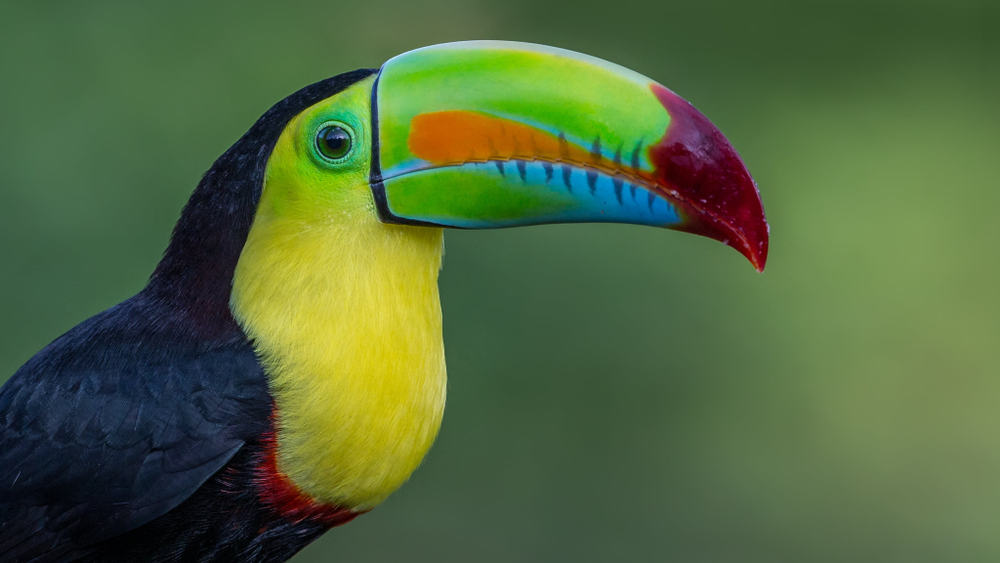

In [ ]:
img_url = "https://www.atshq.org/wp-content/uploads/2022/07/shutterstock_1626122512.jpg"
img = httpx.get(img_url).content
display(Image(img, width=360, height=360))

In [ ]:
msg = mk_msg([img, "describe this picture"], api="openai")
_, text = openai_chat([msg])
text

'This image features a toucan, recognizable by its large, colorful beak. The bird has a striking yellow throat and chest, with black feathers on its back and head. The beak is a vibrant mix of colors, including green, red, and blue, creating a visually stunning contrast against the blurred green background. Toucans are known for their unique and impressive beaks, which they use to reach for fruit in trees.'

In [ ]:
msg = mk_msg([img, "describe this picture"], api="anthropic")
_, text = anthropic_chat([msg])
text

'The image shows a colorful toucan bird. The toucan has a large, distinctive beak that is predominantly green in color with blue, orange, and red accents. The body of the bird is primarily yellow, with black feathers covering its wings and back. The toucan is perched against a blurred green background, highlighting its vibrant and eye-catching appearance.'

Great! Before moving on let's create `mk_img` to make our code a little DRY'r. 

In [ ]:
#| export
def _mk_img(data:bytes)->tuple:
    "Convert image bytes to a base64 encoded image"
    img = base64.b64encode(data).decode("utf-8")
    mtype = mimetypes.types_map["."+imghdr.what(None, h=data)]
    return img, mtype

Let's use `mk_img` in our `Msg` subclasses

In [ ]:
class OpenAiMsg(Msg):
    "Helper class to create a message for the OpenAI API."
    def img_msg(self, data:bytes)->dict:
        "Convert `data` to an image message"
        img, mtype = _mk_img(data)
        r = {"url": f"data:{mtype};base64,{img}"}
        return {"type": "image_url", "image_url": r}

class AnthropicMsg(Msg):
    "Helper class to create a message for the Anthropic API."
    def img_msg(self, data:bytes)->dict:
        "Convert `data` to an image message"
        img, mtype = _mk_img(data)
        r = {"type": "base64", "media_type": mtype, "data":img}
        return {"type": "image", "source": r}

### Text Only Models

Ok, what next? Some text only models that follow the OpenAI API spec such as Deepseek, expect messages to have the following format

```json
{"role": "user", "content": "Hello, world!"}
```

Let's update our code to support this use-case.

In [ ]:
class Msg:
    "Helper class to create a message for the OpenAI and Anthropic APIs."
    def __call__(self, role:str, content:[list, str], text_only:bool=False, **kw)->dict:
        "Create an OpenAI/Anthropic compatible message with `role` and `content`."
        if content is not None and not isinstance(content, list): content = [content]
        content = [self.mk_content(o, text_only=text_only) for o in content] if content else ''
        return dict(role=role, content=content[0] if text_only else content, **kw)
    
    def img_msg(self, *args, **kw)->dict: 
        "Convert bytes to an image message"
        ...
        
    def text_msg(self, s:str, text_only=False, **kw): 
        "Convert `s` to a text message"
        return s if text_only else {"type":"text", "text":s}
    
    def mk_content(self, content, text_only=False, **kw):
        if isinstance(content, str): return self.text_msg(content, text_only=text_only)
        if isinstance(content, bytes): return self.img_msg(content)
        return content

class OpenAiMsg(Msg):
    "Helper class to create a message for the OpenAI API."
    def img_msg(self, data)->dict:
        "Convert `data` to an image message"
        img, mtype = mk_img(data)
        r = {"url": f"data:{mtype};base64,{img}"}
        return {"type": "image_url", "image_url": r}

class AnthropicMsg(Msg):
    "Helper class to create a message for the Anthropic API."
    def img_msg(self, data)->dict:
        "Convert `data` to an image message"
        img, mtype = mk_img(data)
        r = dict(type='base64', media_type=mtype, data=img)
        return {"type": "image", "source": r}

In [ ]:
#| export
def mk_msg(content:[list,str], role:str="user", *args, api:str="openai", text_only=False, **kw)->dict:
    "Create an OpenAI/Anthropic compatible message."
    if text_only and not isinstance(content, str): raise("`content` muse be a string for `text_only` models.")
    m = OpenAiMsg if api == "openai" else AnthropicMsg
    return m()(role, content, text_only=text_only, **kw)

In [ ]:
mk_msg("describe this picture", text_only=True)

{'role': 'user', 'content': 'describe this picture'}

In [ ]:
mk_msg("describe this picture")

{'role': 'user',
 'content': [{'type': 'text', 'text': 'describe this picture'}]}

### Conversation

LLMs are stateless. To continue a conversation we need to include the entire message history in every API call.
By default the role in each message alternates between `user` and `assistant`.

Let's add a method that alternates the roles for us and then calls `mk_msgs`.

In [ ]:
#| export
def mk_msgs(msgs: list, *args, api:str="openai", **kw) -> list:
    "Create a list of messages compatible with OpenAI/Anthropic."
    if isinstance(msgs, str): msgs = [msgs]
    return [mk_msg(o, ('user', 'assistant')[i % 2], *args, api=api, **kw) for i, o in enumerate(msgs)]

In [ ]:
mk_msgs(["Hello", "Some assistant response", "tell me a joke"])

[{'role': 'user', 'content': [{'type': 'text', 'text': 'Hello'}]},
 {'role': 'assistant',
  'content': [{'type': 'text', 'text': 'Some assistant response'}]},
 {'role': 'user', 'content': [{'type': 'text', 'text': 'tell me a joke'}]}]

### API Response

To make our lives even easier, it would be nice if `mk_msg` could format the raw API response from a previous API call so that we can pass it straight to `mk_msgs`.

In [ ]:
#| export
class Msg:
    "Helper class to create a message for the OpenAI and Anthropic APIs."
    def __call__(self, role:str, content:[list, str], text_only:bool=False, **kw)->dict:
        "Create an OpenAI/Anthropic compatible message with `role` and `content`."
        if hasattr(content, "content"): content, role = content.content, content.role
        content = self.find_block(content)
        if content is not None and not isinstance(content, list): content = [content]
        content = [self.mk_content(o, text_only=text_only) for o in content] if content else ''
        return dict(role=role, content=content[0] if text_only else content, **kw)

    def find_block(self, r)->dict:
        ...

    def text_msg(self, s:str, text_only:bool=False, **kw):
        "Convert `s` to a text message"
        return s if text_only else {"type":"text", "text":s}

    def img_msg(self, *args, **kw)->dict:
        "Convert bytes to an image message"
        ...

    def mk_content(self, content:[str, bytes], text_only:bool=False) -> dict:
        "Create the appropriate data structure based the content type."
        if isinstance(content, str): return self.text_msg(content, text_only=text_only)
        if isinstance(content, bytes): return self.img_msg(content)
        return content

In [ ]:
#| export
class AnthropicMsg(Msg):
    def img_msg(self, data: bytes) -> dict:
        "Convert `data` to an image message"
        img, mtype = mk_img(data)
        r = {"type": "base64", "media_type": mtype, "data":img}
        return {"type": "image", "source": r}

    def find_block(self, r):
        "Find the message in `r`."
        return r.get('content', r) if isinstance(r, abc.Mapping) else r

In [ ]:
#| export
class OpenAiMsg(Msg):
    def img_msg(self, data: bytes) -> dict:
        "Convert `data` to an image message"
        img, mtype = mk_img(data)
        r = {"url": f"data:{mtype};base64,{img}"}
        return {"type": "image_url", "image_url": r}

    def find_block(self, r):
        "Find the message in `r`."
        if type(r).__module__ == "builtins": return r
        m = nested_idx(r, "choices", 0)
        if not m: return m
        if hasattr(m, "message"): return m.message.content
        return m.delta

Let's test our changes.

In [ ]:
msgs = ["tell me a joke"]
r, text = openai_chat(mk_msgs(msgs))
text

'Why did the scarecrow win an award? \n\nBecause he was outstanding in his field!'

In [ ]:
msgs += [r, "tell me another joke that's similar to your first joke"]
r, text = openai_chat(mk_msgs("openai", msgs))
text

'OpenAI is an artificial intelligence research organization focused on developing and promoting friendly AI for the benefit of humanity. Founded in December 2015, OpenAI conducts research in a variety of areas related to AI, including natural language processing, reinforcement learning, computer vision, and more. It is known for creating advanced models like GPT (Generative Pre-trained Transformer), which can generate human-like text based on the input it receives. OpenAI aims to advance AI technology while also ensuring that it is used safely and responsibly. If you have specific questions about OpenAI or its technologies, feel free to ask!'

### Usage

To make `msglm` a little easier to use let's create OpenAI and Anthropic wrappers for `mk_msg` and `mk_msgs`.

In [ ]:
#| export
mk_msg_openai = partial(mk_msg, api="openai")
mk_msgs_openai = partial(mk_msgs, api="openai")

In [ ]:
mk_msg_anthropic = partial(mk_msg, api="anthropic")
mk_msgs_anthropic = partial(mk_msgs, api="anthropic")

If you're using OpenAI you should be able to use the import below

```python
from msglm import mk_msg_openai as mk_msg, mk_msgs_openai as mk_msgs
```

Similarily for Anthropic

```python
from msglm import mk_msg_anthropic as mk_msg, mk_msgs_anthropic as mk_msgs
```

### Caching
Anthropic currently offers [prompt caching](https://docs.anthropic.com/en/docs/build-with-claude/prompt-caching), which can reduce cost and latency.

To cache a message, we simply add a `cache_control` field to our content as shown below.

```js
{
    "role": "user",
    "content": [
        {
            "type": "text",
            "text": "Hello, can you tell me more about the solar system?",
            "cache_control": {"type": "ephemeral"}
        }
    ]
}
```

Let's update our `mk_msg` and `mk_msgs` Anthropic wrappers to support caching.

In [ ]:
#| export
def _add_cache_control(msg, cache=False):
    "cache `msg`."
    if cache: msg["content"][-1]["cache_control"] = {"type": "ephemeral"}
    return msg

@delegates(mk_msg)
def mk_msg_anthropic(*args, cache=False, **kwargs):
    "Create an Anthropic compatible message."
    msg = partial(mk_msg, api="anthropic")(*args, **kwargs)
    return _add_cache_control(msg, cache=cache)

@delegates(mk_msgs)
def mk_msgs_anthropic(*args, cache=False, **kwargs):
    "Create a list of Anthropic compatible messages."
    msgs = partial(mk_msgs, api="anthropic")(*args, **kwargs)
    return [_add_cache_control(msg, cache=cache) for msg in msgs]

Let's see caching in action

In [ ]:
mk_msg_anthropic("Don't cache my message")

{'role': 'user',
 'content': [{'type': 'text', 'text': "Don't cache my message"}]}

In [ ]:
mk_msg_anthropic("Please cache my message", cache=True)

{'role': 'user',
 'content': [{'type': 'text',
   'text': 'Please cache my message',
   'cache_control': {'type': 'ephemeral'}}]}

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()